# Geospatial analysis

This notebook contains the geospatial analysis.

## Setup the Google Colab environment

First we need to install and import all needed libraries.

In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.3 MB/s eta 0:00:00


In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/gdrive')

# Import Libraries
import pandas as pd
import os
import ast
from google.colab import drive
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString

Mounted at /gdrive


## Load the data

We need to import all the preprocessed and NLP labeled data. 

In [3]:
# Set Directory Path & Filename NLP Tweets
directoryPathNLP = '/gdrive/MyDrive/TwitterData_GroupB/Data/AnalysisData/'
fileNameNLP = 'Tweets.csv'

# Set Directory Path & Filename GeoTweets
directoryPathGEO = '/gdrive/MyDrive/TwitterData_GroupB/Data/Preprocessed/'
fileNameGEO = 'tweets.csv'

# Import Data
tweetsNLP = pd.read_csv(directoryPathNLP + fileNameNLP)
tweetsGEO = pd.read_csv(directoryPathGEO + fileNameGEO)

print(tweetsNLP.info())
print(tweetsGEO.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1051 non-null   int64  
 1   id             1051 non-null   int64  
 2   text           1051 non-null   object 
 3   sentiment      1051 non-null   object 
 4   sentiment_num  1051 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 41.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   1051 non-null   int64 
 1   author_id            1051 non-null   int64 
 2   text                 1051 non-null   object
 3   conversation_id      1051 non-null   int64 
 4   in_reply_to_user_id  1051 non-null   int64 
 5   sender_location      1051 non-null   object
 6   receiver_locati

Now we need to join both dataframes (the dataframe with the sentiment score and the dataframe with the pre-processed tweet dataset with geospatial information) so that we have a complete dataframe for our spatial analysis.

In [4]:
# Join Dataframes
tweets = pd.merge(tweetsGEO, tweetsNLP, on='id', right_index=False, left_index=False)

# Set List for Useful Columns
usefulColumns = ['id', 'author_id', 'in_reply_to_user_id', 'sender_location', 'receiver_location', 'sentiment_num']
# Remove Unused Columns
tweets = tweets.loc[:, usefulColumns]

# Check Amount of Unique Pairs
unique_pairs = tweets.groupby(['author_id', 'in_reply_to_user_id']).ngroups
print("Number of unique pairs:", unique_pairs)

print(tweets.info())
tweets.head()

Number of unique pairs: 743
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1051 non-null   int64  
 1   author_id            1051 non-null   int64  
 2   in_reply_to_user_id  1051 non-null   int64  
 3   sender_location      1051 non-null   object 
 4   receiver_location    1051 non-null   object 
 5   sentiment_num        1051 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 57.5+ KB
None


,id,author_id,in_reply_to_user_id,sender_location,receiver_location,sentiment_num
0,1641769213462302721,21298074,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0.0
1,1641769076153368578,21298074,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0.0
2,1641765800250843136,143788349,365677125,"[4.6750992, 51.9056092, 4.8323339, 51.9841161]","[4.1903465, 52.0148713, 4.4224441, 52.1388646]",0.5
3,1641760234489167873,123950495,7167342,"[5.7576521, 51.7905544, 5.9082602, 51.8947409]","[5.1830769, 51.3055699, 5.3137105, 51.4365525]",0.0
4,1641756738385854465,940899377543110656,48287280,"[5.2121062, 50.8677279, 5.4145591, 50.9815265]","[4.774005, 50.9533704, 4.9369701, 51.0376519]",0.0


## Prepare the data

Now we are going to prepare the dataframe. We will need to add two columns, one for the count of a certain user interaction and one for the average sentiment. 

In [5]:
# Group By User Interaction and Count Interactions to Make Count Column
tweets['count'] = tweets.groupby(['author_id', 'in_reply_to_user_id']).author_id.transform(lambda x: x.count())

# Group By User Interaction and Compute Average Sentiment 
tweets['sentiment_avg'] = tweets.groupby(['author_id', 'in_reply_to_user_id']).sentiment_num.transform(lambda x: x.mean())

# Check Dataset
print(tweets.info())
tweets.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1051 non-null   int64  
 1   author_id            1051 non-null   int64  
 2   in_reply_to_user_id  1051 non-null   int64  
 3   sender_location      1051 non-null   object 
 4   receiver_location    1051 non-null   object 
 5   sentiment_num        1051 non-null   float64
 6   count                1051 non-null   int64  
 7   sentiment_avg        1051 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 73.9+ KB
None


,id,author_id,in_reply_to_user_id,sender_location,receiver_location,sentiment_num,count,sentiment_avg
0,1641769213462302721,21298074,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0.0,2,0.0
1,1641769076153368578,21298074,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0.0,2,0.0
2,1641765800250843136,143788349,365677125,"[4.6750992, 51.9056092, 4.8323339, 51.9841161]","[4.1903465, 52.0148713, 4.4224441, 52.1388646]",0.5,2,0.5
3,1641760234489167873,123950495,7167342,"[5.7576521, 51.7905544, 5.9082602, 51.8947409]","[5.1830769, 51.3055699, 5.3137105, 51.4365525]",0.0,3,0.0
4,1641756738385854465,940899377543110656,48287280,"[5.2121062, 50.8677279, 5.4145591, 50.9815265]","[4.774005, 50.9533704, 4.9369701, 51.0376519]",0.0,1,0.0


Now we want to drop the duplicate rows, so that we only have the rows with unique user pairs

In [6]:
# Drop Duplicate User Pairs
GeoSpatialTweets = tweets.drop_duplicates(subset=['author_id', 'in_reply_to_user_id'], keep='first')

# Check Dataset
print(tweets.info())
print(GeoSpatialTweets.info())
GeoSpatialTweets

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1051 non-null   int64  
 1   author_id            1051 non-null   int64  
 2   in_reply_to_user_id  1051 non-null   int64  
 3   sender_location      1051 non-null   object 
 4   receiver_location    1051 non-null   object 
 5   sentiment_num        1051 non-null   float64
 6   count                1051 non-null   int64  
 7   sentiment_avg        1051 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 73.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 0 to 1050
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   743 non-null    int64  
 1   author_id            743 non-null    int64  
 2   in_reply_to_user

,id,author_id,in_reply_to_user_id,sender_location,receiver_location,sentiment_num,count,sentiment_avg
0,1641769213462302721,21298074,454142767,"[-4.7764112, 36.4863005, -4.5921218, 36.6255465]","[4.7946271, 52.1615468, 5.0217418, 52.3041119]",0.0,2,0.0
2,1641765800250843136,143788349,365677125,"[4.6750992, 51.9056092, 4.8323339, 51.9841161]","[4.1903465, 52.0148713, 4.4224441, 52.1388646]",0.5,2,0.5
3,1641760234489167873,123950495,7167342,"[5.7576521, 51.7905544, 5.9082602, 51.8947409]","[5.1830769, 51.3055699, 5.3137105, 51.4365525]",0.0,3,0.0
4,1641756738385854465,940899377543110656,48287280,"[5.2121062, 50.8677279, 5.4145591, 50.9815265]","[4.774005, 50.9533704, 4.9369701, 51.0376519]",0.0,1,0.0
5,1641738920630140932,1030457076286406656,370875348,"[4.1903465, 52.0148713, 4.4224441, 52.1388646]","[4.9702867, 52.0262429, 5.1952468, 52.142137]",0.0,1,0.0
...,...,...,...,...,...,...,...,...
1046,1645829382504607746,1595576580,365336412,"[4.869447, 52.88374, 5.1786202, 53.0464328]","[4.828954, 51.5098962, 4.9797813, 51.6162215]",-0.5,1,-0.5
1047,1645821180597641219,78105922,329596333,"[4.9702867, 52.0262429, 5.1952468, 52.142137]","[-8.0064946, 36.9630652, -7.8077625, 37.1457884]",1.0,1,1.0
1048,1645782958920413191,1232934583915700227,342689198,"[4.1903465, 52.0148713, 4.4224441, 52.1388646]","[9.8285635, 49.822787, 9.87109, 49.852266]",0.0,1,0.0
1049,1645755183979192322,95500771,412164961,"[3.8070553, 43.5673509, 3.9414797, 43.6534408]","[5.7270313, 52.0732616, 6.0785368, 52.2855541]",0.5,1,0.5


For privacy concerns and to further improve efficiency, we will now drop columns again so that we only use columns that are needed for our analysis. We only need the geospatial data and sentiment to anser our research questions. 

In [7]:
# Set List of Columns to Keep
columnsToKeep = ['sender_location', 'receiver_location', 'count', 'sentiment_avg']
# Drop Columns
geoSpatialTweets = GeoSpatialTweets.loc[:, columnsToKeep]

print(geoSpatialTweets.info())
geoSpatialTweets.head()

geoSpatialTweets.to_excel('/gdrive/MyDrive/TwitterData_GroupB/Data/Visualisation/testDataframe.xlsx', sheet_name='resultsgeoref')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 0 to 1050
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sender_location    743 non-null    object 
 1   receiver_location  743 non-null    object 
 2   count              743 non-null    int64  
 3   sentiment_avg      743 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 29.0+ KB
None


## Create the geometries

After this we define the functions for computing the center of the bounding boxes and split the tuples in two columns creating 4 new columns. Longitude and Latitude for sender and receiver. These 4 seperate columns are not used in this notebook, but we made them in case we need it for visualising the points when we make a StoryMap (sometimes when working in ArcGIS seperate columns for longitude and latitude are used in tools). The center of the bounding box is used because an exact location is not known.

In [8]:
def parse_coordinates(s):
    '''This function transforms the string in the original dataset to a tuple with float 64 type values.
    Returns a tuple that is fitted for input in the compute_central_point function'''
    return ast.literal_eval(s)


def compute_central_point(bbox):
    '''This function computes the central point of a bounding box.
    It takes a bounding box as a tuple, assigns the values to variables and calculates the middle with those variables.
    Returns a tuple which is the central point of the bounding box'''

    # Extract the bounding box coordinates
    xmin, ymin, xmax, ymax = bbox

    # Compute the central point coordinates
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2

    return x_center, y_center


def box_to_point(input_tweets, colum_send, colum_rec):
    '''This funtion computes the central points of all bounding boxes.
    It uses the funtcions parse_coordinates and compute_central_point.
    Returns two new columns witht the coordinates of the central points for the receiver and sender'''

    # Change Type of Columns by applying the parse_coordinates function on all rows
    input_tweets['sender_location'] = input_tweets['sender_location'].apply(parse_coordinates)
    input_tweets['receiver_location'] = input_tweets['receiver_location'].apply(parse_coordinates)

    # transform bounding boxes to central point locations
    input_tweets[colum_send] = input_tweets[colum_send].apply(compute_central_point)
    input_tweets[colum_rec] = input_tweets[colum_rec].apply(compute_central_point)

    return input_tweets


# define a function to split the tuples into two columns
def split_tuple(row):
    '''This function stplits the tuple (the central points) into two columns (longitude and latitude).
    It takes a rown number for a specific column and uses indexing to select the right value in the tuple to assign to the right column name.
    Returns two new columns with two new values (latitude and longitude)'''
    
    return pd.Series({'longitudeSend': row[0], 'latitudeSend': row[1]})

def split_tuple2(row):
    '''Same function as split tuple but this one works for the receiver_location column'''
    return pd.Series({'longitudeRec': row[0], 'latitudeRec': row[1]})

Now we call the function box_to_point to compute the center of all bounding boxes in the dataframe. And call the functions split tuple and split tuple2 to get the longitude/latitude columns

In [9]:
#apply the function box_to_point to calculate the centers of the bounding boxes
box_to_point(geoSpatialTweets, 'sender_location', 'receiver_location')

# apply the function to the column and join the result with the original dataframe
georef_tweets = geoSpatialTweets.join(geoSpatialTweets['sender_location'].apply(split_tuple))
georef_tweets = georef_tweets.join(geoSpatialTweets['receiver_location'].apply(split_tuple2))

georef_tweets.head()

,sender_location,receiver_location,count,sentiment_avg,longitudeSend,latitudeSend,longitudeRec,latitudeRec
0,"(-4.6842665, 36.5559235)","(4.90818445, 52.23282935)",2,0.0,-4.684266,36.555923,4.908184,52.232829
2,"(4.75371655, 51.944862650000005)","(4.3063953, 52.07686795)",2,0.5,4.753717,51.944863,4.306395,52.076868
3,"(5.832956149999999, 51.84264765)","(5.248393699999999, 51.3710612)",3,0.0,5.832956,51.842648,5.248394,51.371061
4,"(5.3133326499999995, 50.9246272)","(4.855487549999999, 50.99551115)",1,0.0,5.313333,50.924627,4.855488,50.995511
5,"(4.3063953, 52.07686795)","(5.082766749999999, 52.084189949999995)",1,0.0,4.306395,52.076868,5.082767,52.084190


Here we also add a column with the lines between the points as a linestring object. We also do this because line features are easier to visualise in matplotlib and ArcGIS.

In [10]:
# add column with lines between points as line features 
georef_tweets['Line'] = georef_tweets.apply(lambda row: LineString([Point(row['sender_location']), Point(row['receiver_location'])]), axis=1)

print(georef_tweets.info())
georef_tweets.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 0 to 1050
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sender_location    743 non-null    object 
 1   receiver_location  743 non-null    object 
 2   count              743 non-null    int64  
 3   sentiment_avg      743 non-null    float64
 4   longitudeSend      743 non-null    float64
 5   latitudeSend       743 non-null    float64
 6   longitudeRec       743 non-null    float64
 7   latitudeRec        743 non-null    float64
 8   Line               743 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 74.2+ KB
None


,sender_location,receiver_location,count,sentiment_avg,longitudeSend,latitudeSend,longitudeRec,latitudeRec,Line
0,"(-4.6842665, 36.5559235)","(4.90818445, 52.23282935)",2,0.0,-4.684266,36.555923,4.908184,52.232829,"LINESTRING (-4.6842665 36.5559235, 4.90818445 ..."
2,"(4.75371655, 51.944862650000005)","(4.3063953, 52.07686795)",2,0.5,4.753717,51.944863,4.306395,52.076868,"LINESTRING (4.75371655 51.944862650000005, 4.3..."
3,"(5.832956149999999, 51.84264765)","(5.248393699999999, 51.3710612)",3,0.0,5.832956,51.842648,5.248394,51.371061,"LINESTRING (5.832956149999999 51.84264765, 5.2..."
4,"(5.3133326499999995, 50.9246272)","(4.855487549999999, 50.99551115)",1,0.0,5.313333,50.924627,4.855488,50.995511,"LINESTRING (5.3133326499999995 50.9246272, 4.8..."
5,"(4.3063953, 52.07686795)","(5.082766749999999, 52.084189949999995)",1,0.0,4.306395,52.076868,5.082767,52.084190,"LINESTRING (4.3063953 52.07686795, 5.082766749..."


Create a GeoPandas DataFrame with the newly made line features as geometry column.

In [11]:
tweets_gdf = gpd.GeoDataFrame(georef_tweets, geometry='Line')

In [12]:
#set the current coordinate reference system and change it to EPSG:28992 to get the coordinates in meters
tweets_gdf.crs = 'EPSG:4326'
tweets_gdf = tweets_gdf.to_crs('EPSG:28992')

#calculate the length 
tweets_gdf['Length'] = tweets_gdf['Line'].length

Now we need to change back the coordinate reference system to EPSG:4326 to make it compatible with webmapping to make our final StoryMap. It is also good to convert the Length column to kilometers. This is easier to interpret in the spatial analysis later on.

In [13]:
#set coordinate reference system back to EPSG:4326
tweets_gdf = tweets_gdf.to_crs('EPSG:4326')

# convert to km
tweets_gdf['Length'] = tweets_gdf['Length'] / 1000

tweets_gdf.head()
tweets_gdf.to_excel('/gdrive/MyDrive/TwitterData_GroupB/Data/Visualisation/testVisualisationDataframe.xlsx', sheet_name='resultsgeoref')

## Visualize the sentiments

Now we have all information we need for the visualisation in one dataframe:
- The count (amount of times a specific combination of sender and receiver message eichother) --> used for thinkness of the lines
- The sentiment_avg (a value between -1 and 1 indicating the sentiment, 1 very positive -1 very negative) --> used for color of the the lines (red=negative, green=positive)
- The lines

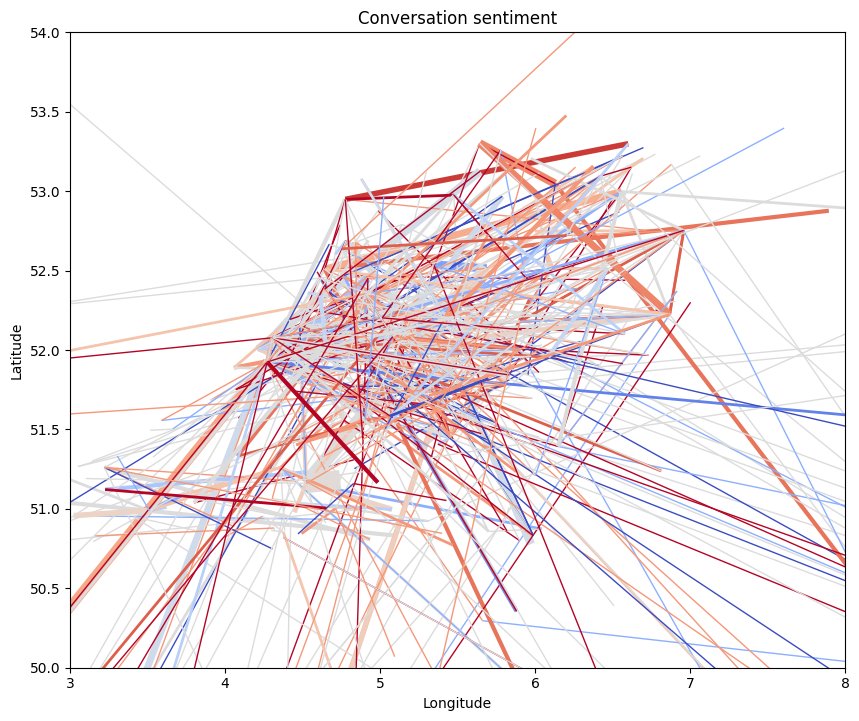

In [14]:
# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the lines with thickness based on column 2 and color based on column 3
tweets_gdf.plot(ax=ax, column='sentiment_avg', cmap='coolwarm', linewidth=tweets_gdf['count'])

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Conversation sentiment')
plt.xlim(3, 8)
plt.ylim(50, 54)

# Show the plot
plt.show()

As we can see this is still quite unclear. First we should delete the lines that go to or come from outside the Netherlands.

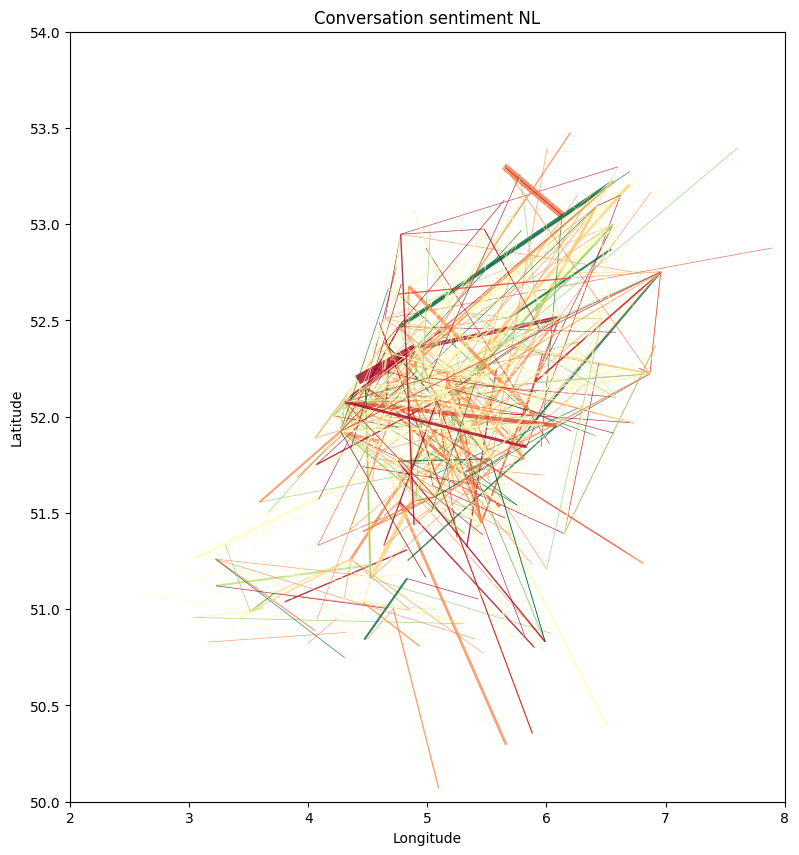

In [15]:
# Set the coordinate bounds
xmin, xmax, ymin, ymax = 2, 8, 50, 54

# Filter the geodataframe based on the coordinate bounds
tweets_gdf_NL = tweets_gdf[(tweets_gdf.bounds["minx"] >= xmin) &
                           (tweets_gdf.bounds["maxx"] <= xmax) &
                           (tweets_gdf.bounds["miny"] >= ymin) &
                           (tweets_gdf.bounds["maxy"] <= ymax)]

# Filter the linestrings based on the coordinate bounds
tweets_gdf_NL = tweets_gdf_NL[tweets_gdf_NL["Line"].apply(lambda x: x.coords[0][0] >= xmin and x.coords[0][0] <= xmax and x.coords[0][1] >= ymin and x.coords[0][1] <= ymax)]

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Set the axis limits
plt.xlim(2, 8)
plt.ylim(50, 54)


# Plot the lines with thickness based on column 2 and color based on column 3
tweets_gdf_NL.plot(ax=ax, column='sentiment_avg', cmap='RdYlGn_r', linewidth=tweets_gdf['count']*0.5, alpha=0.8)

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Conversation sentiment NL')

# Show the plot
plt.show()

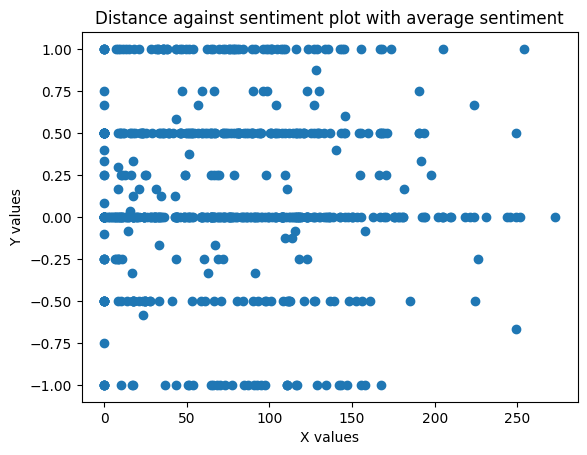

In [16]:
# Plot a scatter plot of 'Length' against 'sentiment_avg'
plt.scatter(tweets_gdf_NL['Length'], tweets_gdf_NL['sentiment_avg'])

plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Distance against sentiment plot with average sentiment')
plt.show()

In [ ]:
tweets_gdf_NL.head()

,sender_location,receiver_location,count,sentiment_avg,longitudeSend,latitudeSend,longitudeRec,latitudeRec,Line,Length
2,"(4.75371655, 51.944862650000005)","(4.3063953, 52.07686795)",2,0.5,4.753717,51.944863,4.306395,52.076868,"LINESTRING (4.75372 51.94486, 4.30640 52.07687)",34.042729
3,"(5.832956149999999, 51.84264765)","(5.248393699999999, 51.3710612)",3,0.0,5.832956,51.842648,5.248394,51.371061,"LINESTRING (5.83296 51.84265, 5.24839 51.37106)",66.274971
4,"(5.3133326499999995, 50.9246272)","(4.855487549999999, 50.99551115)",1,0.0,5.313333,50.924627,4.855488,50.995511,"LINESTRING (5.31333 50.92463, 4.85549 50.99551)",33.120398
5,"(4.3063953, 52.07686795)","(5.082766749999999, 52.084189949999995)",1,0.0,4.306395,52.076868,5.082767,52.084190,"LINESTRING (4.30640 52.07687, 5.08277 52.08419)",53.225982
6,"(4.6176119, 51.9995256)","(4.8521976, 52.2862412)",1,1.0,4.617612,51.999526,4.852198,52.286241,"LINESTRING (4.61761 51.99953, 4.85220 52.28624)",35.714184


Now we can also plot only the high and low sentiment conversations and leave out the neutral ones. Just to have a short look at the distribution (because as can be seen in the previous plot there are many neutral values for sentiment).

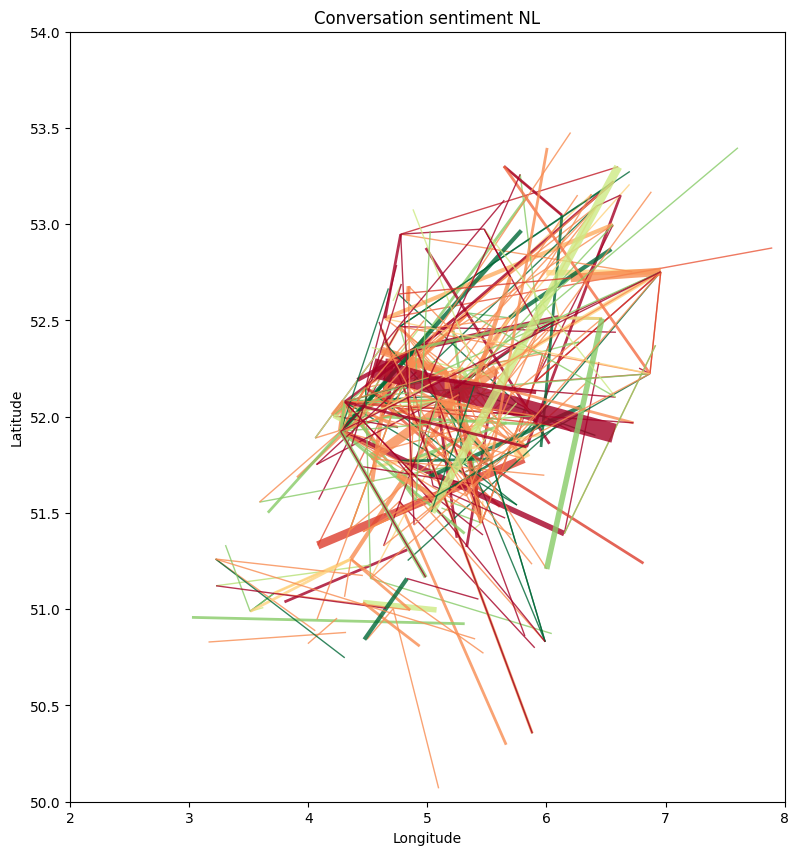

In [17]:
# filter geodataframe to show only high and low sentiment values
tweets_gdf_extremes = tweets_gdf_NL[(tweets_gdf_NL['sentiment_avg'] < -0.2) | (tweets_gdf_NL['sentiment_avg'] > 0.2)]

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Set the axis limits
plt.xlim(2, 8)
plt.ylim(50, 54)

# Plot the lines with thickness based on column 2 and color based on column 3
tweets_gdf_extremes.plot(ax=ax, column='sentiment_avg', cmap='RdYlGn_r', linewidth=tweets_gdf['count'], alpha=0.8)

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Conversation sentiment NL')

# Show the plot
plt.show()

We can also make histograms of the length and sentiment columns to see the distribution

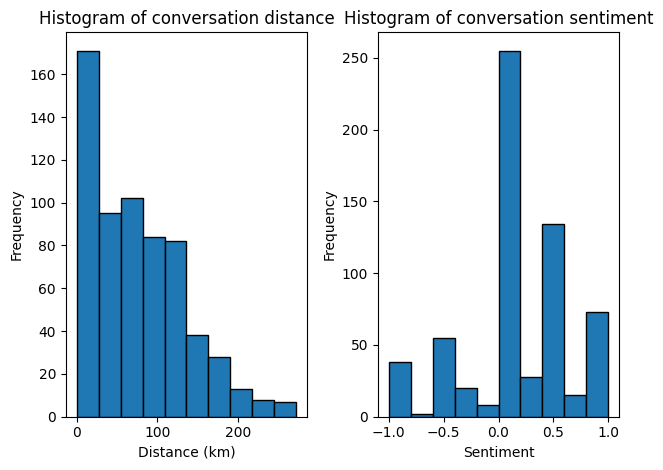

In [18]:
# Make the first histogram of the distance
plt.subplot(1,2,1)
plt.hist(tweets_gdf_NL['Length'], bins=10, edgecolor='black')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Histogram of conversation distance')

# Make the second histogram of the sentiment
plt.subplot(1,2,2)
plt.hist(tweets_gdf_NL['sentiment_avg'], bins=10, edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Histogram of conversation sentiment')

plt.tight_layout()
plt.show()

## Export the results

Now we have some intermediate data visualisations and we are confident the data can be used for final visualisation we can write the geodataframe to a geopackage and a shapefile in order to visualise it in ArcGIS.

In [ ]:
tweets_gdf_NL['receiver_location'] = tweets_gdf_NL['receiver_location'].apply(lambda x: str(x))
tweets_gdf_NL['sender_location'] = tweets_gdf_NL['sender_location'].apply(lambda x: str(x))

# Write the GeoDataFrame to a geopackage
tweets_gdf_NL.to_file('/gdrive/MyDrive/TwitterData_GroupB/Data/Visualisation/tweets_for_visualisation.gpkg', layer='VisualisationTweets', driver='GPKG')

# Write the GeoDataFrame to a shapefile
tweets_gdf_NL.to_file('/gdrive/MyDrive/TwitterData_GroupB/Data/Visualisation/tweets_for_visualisation.shp', driver='ESRI Shapefile')

<ipython-input-25-fe2bd7ca3091>:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  tweets_gdf_NL.to_file('/gdrive/MyDrive/TwitterData_GroupB/Data/Visualisation/tweets_for_visualisation.shp', driver='ESRI Shapefile')


## Discussion

Since bounding boxes were used to ensure privacy protection, conversations that took place within the same bounding box could not be visualized.